# Fractal Generation

In [1]:
# import packages
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute
from qiskit.visualization import plot_histogram
from qiskit_ionq import IonQProvider

# IONQ API
token = 'rwLjV4pRx8bY8RTw5HqEYwbIkdYCK0M4'
provider = IonQProvider(token)

In [2]:
provider.backends()

[<IonQSimulatorBackend('ionq_simulator')>, <IonQQPUBackend('ionq_qpu')>]

In [3]:
# load backend by using the get_backend method
backend = provider.get_backend("ionq_simulator")

In [4]:
# Image Packages
import numpy as np
from PIL import Image
import math

In [5]:
# Open the Image and Convert to Grayscale
image = Image.open('taiji.png').convert('L')

# summarize some details about the image
print(image.size)
print(image.mode)

(8, 8)
L


In [6]:
# Flatten so that we can convert to qubits naturally
img = np.asarray(image).flatten()
img = np.array([0, 255, 0, 0])
print(img)

[  0 255   0   0]


In [7]:
# FRQI Representation

dim = math.ceil(np.log2(img.shape[0])) + 1

q = QuantumRegister(dim, 'q')
qc = QuantumCircuit(q)

for n in range(dim - 1):
    qc.h(n)

qc.barrier()

s = 0
prev = ['0'] * (dim - 1)
for num in range(img.shape[0]):
    s = bin(num)
    s = list(s[2:].zfill(dim - 1))
    for i in range(dim - 1):
        if s[i] != prev[i]:
            qc.x(i)
    # print(s)
    prev = s
    qc.mcry((img[num] / 255 - 0.5) * 2 * np.pi, [i for i in range(dim-1)], dim-1)

# qc.draw()

In [8]:
# import qiskit as qk
# from qiskit import QuantumCircuit, Aer, IBMQ
# from qiskit import transpile, assemble
# from qiskit.tools.jupyter import *
# from qiskit.visualization import plot_histogram
# from math import pi

# qc.measure_all()

# aer_sim = Aer.get_backend('aer_simulator')
# t_qc = transpile(qc, aer_sim)
# qobj = assemble(t_qc, shots=4096)
# result = aer_sim.run(qobj).result()
# counts = result.get_counts(qc)
# print(counts)
# plot_histogram(counts)

In [9]:
# Quantum Fourier Transform (QFT) implementation from Qiskit

def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(np.pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)
    
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

In [10]:
# Apply the QFT on the image representation
qft(qc, dim)
# qc.draw()

{'0': 116, '1': 38, '10': 126, '11': 222, '100': 121, '101': 232, '110': 133, '111': 36}


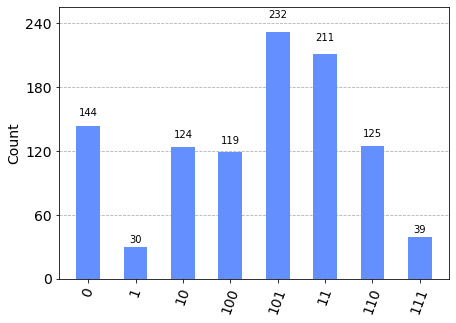

In [11]:
# Measure in two bases to get probability amplitudes

shotno=1024
qc_copy = qc.copy()

# measure in computational basis
job_ionq_z = execute(qc_copy, backend, shots=shotno)
resultqc_z = job_ionq_z.result()
counts_z = resultqc_z.get_counts(qc_copy)
# print(counts_z)
plot_histogram(counts_z)

# measure in x basis
for i in range(dim):
    qc_copy.h(i)
job_ionq_x = execute(qc, backend, shots=shotno)
resultqc_x = job_ionq_x.result()
counts_x = resultqc_x.get_counts(qc_copy)
# print(counts_x)
plot_histogram(counts_x)

In [12]:
# Convert the amplitudes to complex numbers

probz = {}
probx = {}

for num in range(img.shape[0]):
    s = bin(num)[2:]
    if s not in counts_z:
        probz[s] = 0
    else:
        probz[s] = counts_z[s] / shotno
        
    if s not in counts_x:
        probx[s] = 0
    else:
        probx[s] = counts_x[s] / shotno

amps = {}
for key in probz:
    amps[key] = np.sqrt(probz[key]) + np.sqrt(probz[key] * 1j)

In [13]:
print(amps)

{'0': (0.5745657100041537+0.23799290955824715j), '1': (0.32885352957842656+0.13621559198564606j), '10': (0.5988195654223624+0.24803918541230538j), '11': (0.7948536930813774+0.32923917977664807j)}


In [14]:
# Randomly generate a complex offset

qc2 = QuantumCircuit(8)

for i in range(8):
    qc2.h(i)
    
qc2.measure_all()

numbers = []

for i in range(2):
    # measure in computational basis
    job_ionq = execute(qc2, backend, memory=True, shots=1)
    resultqc = job_ionq.result()
    counts = resultqc.get_counts(qc2)
    for key in counts:
        if counts[key] == 1:
            numbers.append(int(key, 2) / 255 * 2 - 1)
            
print(numbers)

[-0.7333333333333334, 0.41176470588235303]


In [16]:
# Generate an animation for a Julia fractal

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from celluloid import Camera
import tqdm

c = numbers[0] + numbers[1] * 1j

print("c= ",c)

# Define the size
size = 1000
heightsize = size
widthsize = size

def julia_set(c=c, height=heightsize, width=widthsize, x=0, y=0, zoom=1, max_iterations=100):
    # To make navigation easier we calculate these values
    x_width = 1.5
    y_height = 1.5*height / width
    x_from = x - x_width / zoom
    x_to = x + x_width / zoom
    y_from = y - y_height / zoom
    y_to = y + y_height / zoom
    
    # Here the actual algorithm starts and the z paramter is defined for the Julia set function
    x = np.linspace(x_from, x_to, width).reshape((1, width))
    y = np.linspace(y_from, y_to, height).reshape((height, 1))
    z = x + 1j * y
    
    # Initialize c to the complex number obtained from the quantum circuit
    c = np.full(z.shape, c)

    # To keep track in which iteration the point diverged
    div_time = np.zeros(z.shape, dtype=int)
    
    # To keep track on which points did not converge so far
    m = np.full(c.shape, True, dtype=bool)
    
    for key in amps:
        amps[key] = np.full(z.shape, amps[key])
    
    for i in range(max_iterations):
        num = z[m]**4 + sum([amps[bin(num)[2:]][m] * z[m] ** ((num // 2)  % 4) for num in range(img.shape[0], 2)])
        den = z[m]**4 + sum([amps[bin(num)[2:]][m] * z[m] ** (((num - 1) // 2) % 4) for num in range(1, img.shape[0], 2)])
        # print(num.shape)
        # print(den.shape)
        z[m] = num / den + c[m]
        m[np.abs(z) > 2] = False
        div_time[m] = i
    # print(div_time.max())
    # print(div_time.min())
    return div_time


fig, ax = plt.subplots(1, 1) 
camera = Camera(fig)
def color(data, i):
    normalizedData = (data - np.min(data)) / (np.max(data) - np.min(data))
    normi = i / frameno
    # print(data.shape)
    rgb = np.zeros((data.shape[0], data.shape[1], 3))
    r = normalizedData*normi
    b = (1 - normi)*normalizedData
    # print(r,b)
    rgb[:,:,0] = r#np.full(rgb[:,:,1].shape, 0)
    rgb[:,:,1] = np.full(rgb[:,:,1].shape, 0)
    rgb[:,:,2] = b#normalizedData
    return rgb

frameno = 50
for i in tqdm.tqdm(range(frameno)):
    ax.imshow(color(julia_set(c=c), i))
    ax.axis('off')
    camera.snap()
    plt.close()
    c += 0.03 + 0.03j
    
anim = camera.animate(blit=True)
anim.save('1qubit_simulator_4animations_H_2' + str(frameno) + ' steps c=' + str(c) + '.gif', writer='imagemagick')

c=  (-0.7333333333333334+0.41176470588235303j)


100%|██████████| 50/50 [02:24<00:00,  2.90s/it]
MovieWriter imagemagick unavailable; using Pillow instead.
